In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

C:\Users\aldoa\anaconda3\envs\env2\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data=pd.read_csv('tempm30min.csv') # 0 a 3600 mediciones
data.columns

Index(['Unnamed: 0', 'coolant', 'stator_winding', 'ambient', 'stator_tooth',
       'stator_yoke', 'pm', 'torque'],
      dtype='object')

In [3]:
data.isna().sum() 
## No hay datos faltantes.

Unnamed: 0        0
coolant           0
stator_winding    0
ambient           0
stator_tooth      0
stator_yoke       0
pm                0
torque            0
dtype: int64

## Significado de la base de datos

Comprende datos obtenidos mediante sensores de un motor sincrono de imán permanente (PMSM) en un banco de pruebas. Los datos fueron obtenidos en la universidad Paderborn, las mediciones se realizaron cada 0.5 segundos (2 Hz).

Fue obtenida de [kaggle](https://www.kaggle.com/datasets/wkirgsn/electric-motor-temperature)

Cada atributo significa:

* *u_q*: tensión del motor (V).
* *coolant*: temperatura del refrigerante del motor (°C).
* *stator_winding*: temperatura del estator (°C).
* *u_d*: voltaje del componente d (V).
* *stator_tooth*: temperatura de los dientes del estator (°C).
* *motor_speed*: velocidad angular del motor (R.P.M.)
* *i_d*: corriente del compoente d motor (A).
* *i_q*: Corriente del componente q (A).
* *pm*: temperatura del imán permanente (°C).
* *stator_yoke*: temperatura del yugo del estator (°C).
* *ambient*: temperatura del ambiente (°C).
* *torque*: par del motor (Nm).
* *profile_id* sesion de medicion (identificador).

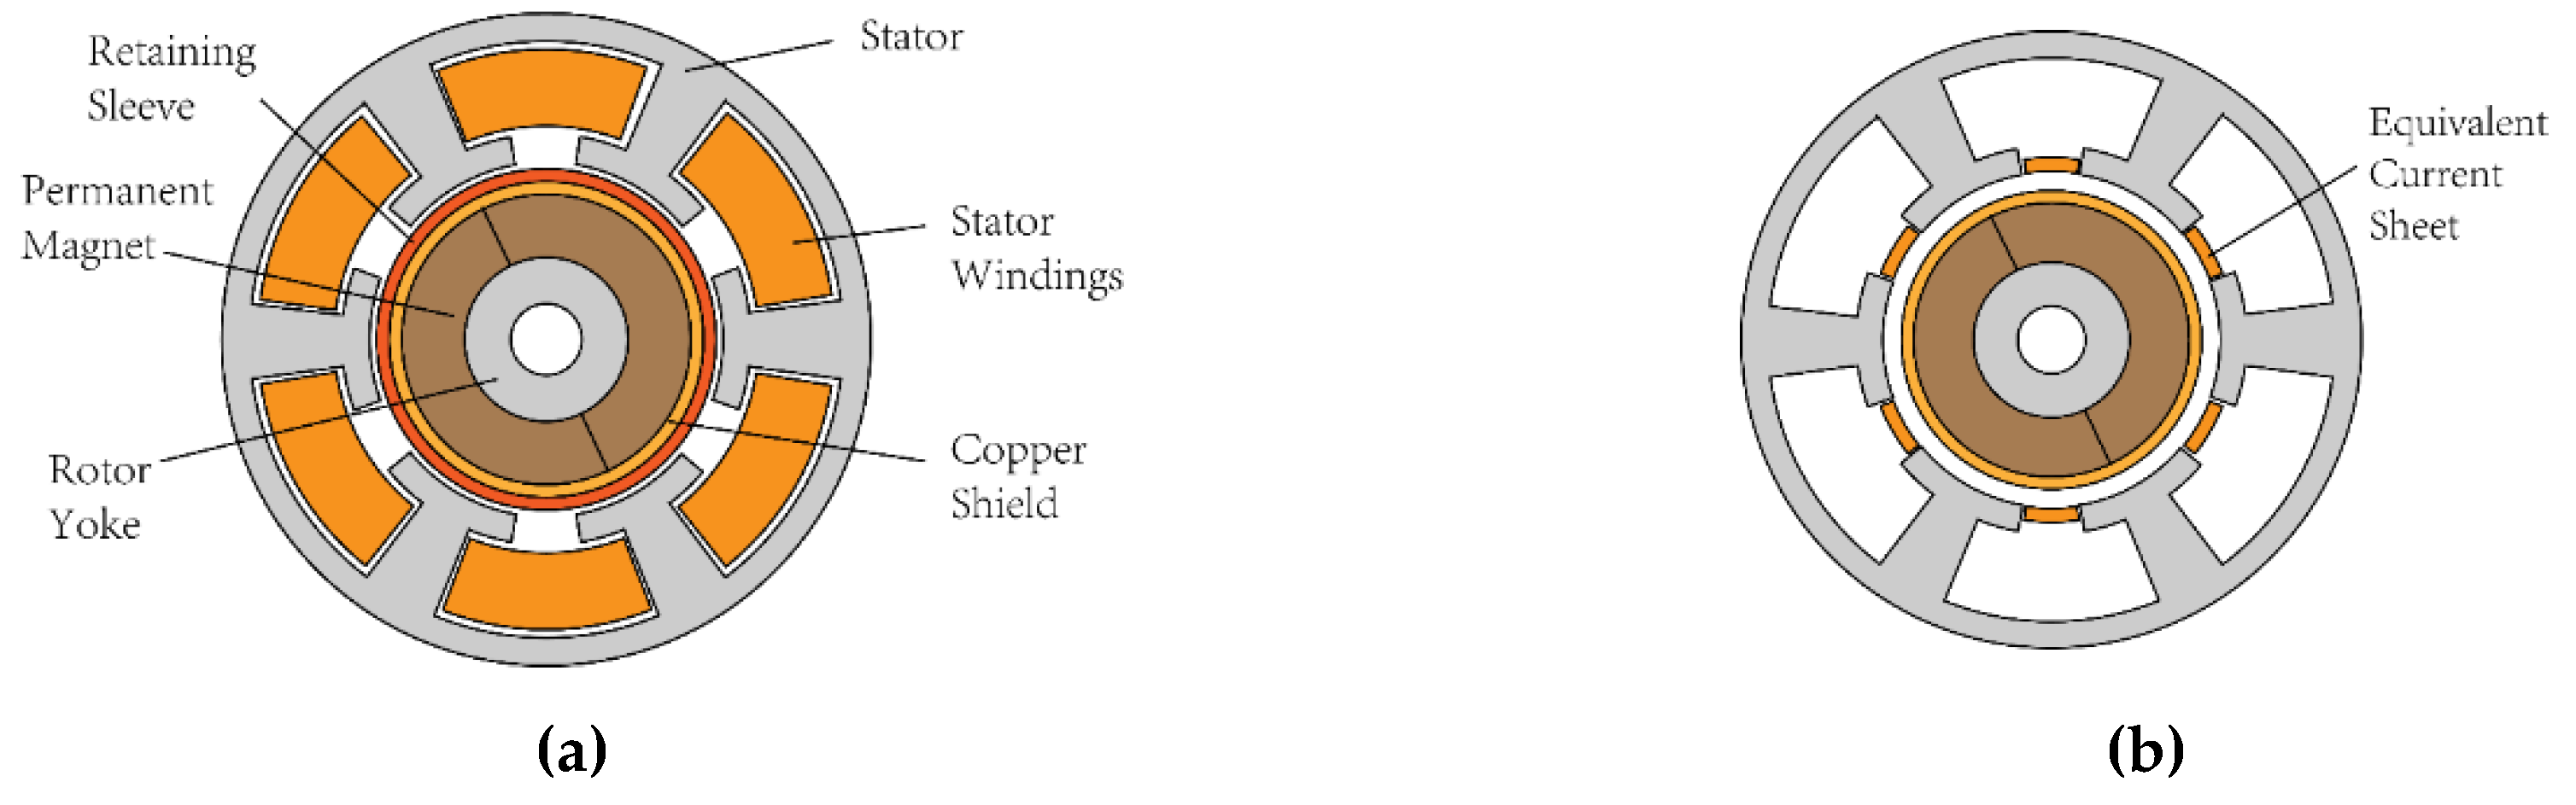

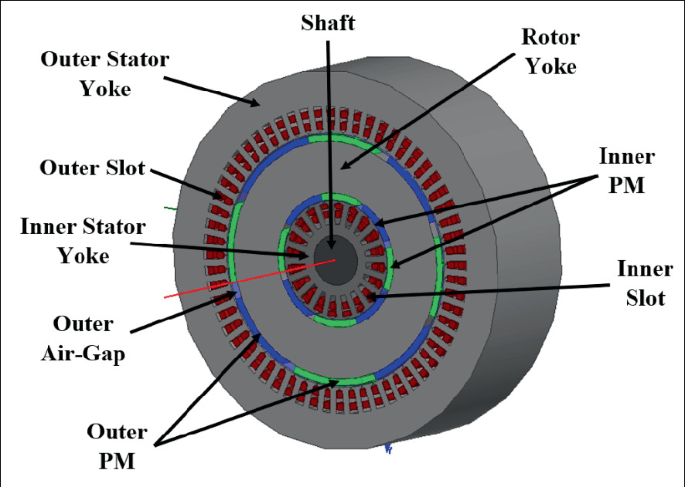

### Consideraciones

Se toma en cuenta un segmento de la prueba total, pues existen muchos estados transitorios que no son de mucho interés, por lo que se tomarán los estados estables con sus respectivas mediciones. **se considera tensión y velocidad constante**.

In [4]:
# seg a min
def mtomin(inicio,fin):
    if inicio>=fin:
        print('error de tiempos')
        return 0
        
    ini=inicio/2
    fi=fin/2
    print('inicio (seg):', ini)
    print('inicio (min):',(ini)/60)
    print('fin (seg):', fin)
    print('fin (min):',(fi)/60)
    print('total de mediciones:', fin-inicio)
    print('tiempo analizado (min):', (fi/60)-(ini/60))

inicio=600
fin=1500
mtomin(inicio,fin)
tiempo=np.arange(inicio,fin)/2 #tiempo reinciado
print(tiempo.shape)

inicio (seg): 300.0
inicio (min): 5.0
fin (seg): 1500
fin (min): 12.5
total de mediciones: 900
tiempo analizado (min): 7.5
(900,)


In [5]:
motor_db=data.copy()
motor_db=motor_db.drop(['Unnamed: 0'],axis=1)
#motor_db.rename(columns={'Unnamed: 0':'tiempo'},inplace=True)
#motor_db['tiempo']=motor_db['tiempo'].replace(tiempo)

# Normalización de valores

Se realizará una normalización min-max entre $a=0$ y $b=1$, con el fin de evitar trabajar con números demasiado grandes.

$$
 v_{norm}=a+\frac{(v_i -v_{min})(b-a)}{v_{max}-v_{min}}
$$

In [6]:
def norm_min_max(x,a,b): # Para todo el dataFrame
    l=list(x.columns)
    v_max=0
    v_min=0
    res=pd.DataFrame()
    for val in l:
        v_max=x[val].max()
        v_min=x[val].min()
        r_dt=v_max-v_min
        r_norm=b-a
        d=x[val]-v_min
        dpct=d/r_dt
        dnorm=r_norm*dpct
        data=a+dnorm
        aa=pd.DataFrame(data,columns=[val])
        res[val]=data
    return res

In [7]:
motor_db_norm=norm_min_max(motor_db,0,1)
print(motor_db_norm.dtypes)

coolant           float64
stator_winding    float64
ambient           float64
stator_tooth      float64
stator_yoke       float64
pm                float64
torque            float64
dtype: object


Index(['coolant', 'stator_winding', 'ambient', 'stator_tooth', 'stator_yoke',
       'pm', 'torque'],
      dtype='object')


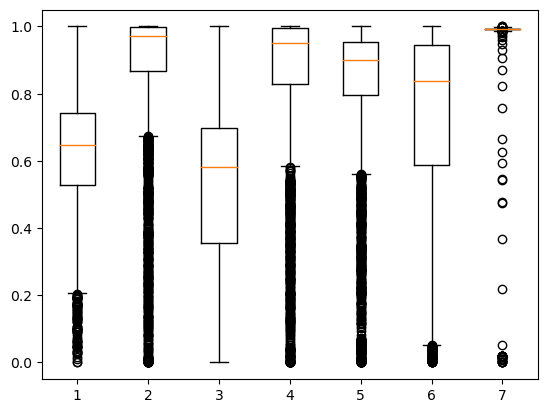

In [8]:
## BOXPLOTS.
bplot=plt.boxplot(motor_db_norm)
print(motor_db_norm.columns)

# Regresión 

Es un método para estudiar la relación entre una variable dependiente $y$ y una variable independiente $x$. La regresión lineal de puede generalizar mediante una función:

$$y=f(x)=\beta_0 + \beta_1 x $$

donde:
* $\beta_0$ y $\beta_1$: son los coeficientes del modelo lineal (ordenada al origen y pendiente de la recta).

Tambien es posible establecer relaciones no lineales con el fin de obtener un modelo que mejor describa el comportamiento de los datos, se le conoce a esto regresión polinomial donde podemos definir al grado $n$ de la función de regresión como:

$$f(x)=\beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \cdots + \beta_n x^n $$

Generalmente se utilizan polinomios no mayores a cuarto y quinto grado ($n=4,5$).

Existen muchos métodos para obtener los coeficientes de la función de regresión, por ejemplo minímos cuadrados, con su respectiva cuantificación del error llamado *error estándar del estimado* y el coeficiente de correlación del modelo.

De manera general se pueden obtener los coeficientes resolviendo un sistema de ecuaciones lineales con la siguiente forma:

$$
\begin{matrix}
 n_d \beta_0 + (\sum x_i)\beta_1 + (\sum x_i^2) \beta_2 + \cdots + (\sum x^n) \beta_n = \sum y_i \\ 
 (\sum x_i)\beta_0 + (\sum x_i^2) \beta_1 + (\sum x_i^3) \beta_2 + \cdots + (\sum x_i^{n+1})\beta_n= \sum x_iy_i \\ 
 (\sum x_i^2) \beta_0 + (\sum x_i^3)\beta_1 + (\sum x_i^4) \beta_2 + \cdots + (\sum x_i^{n+2}) \beta_n =\sum x_i^2y_i \\
 \vdots \\
 (\sum x_i^n)\beta_0 + (\sum x_i^{n+1}) \beta_1 + (\sum x_i^{n+2}) \beta_2 + \cdots + (\sum x_i^{2n})\beta_n= \sum x_i^ny_i \\
\end{matrix}$$

donde:
* $n_d$ es la longitud de los datos
todo esto yendo desde $i=1$ hasta $n_d$ y $n$ el grado del polinomio.

Por otro lado se tiene la regresion polinomial de la función de [*np.polyfit()*](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html) de la cual obtiene los coeficientes a partir de la minimización del error cuadrático:
$$ 
\min(E =\sum_{j=0}^k |p(x_j)-y_j|^2)
$$

### Regresión Lineal Múltiple 

Se obtiene mediante técnicas de machine Learning [regresión multiple](https://rstudio-pubs-static.s3.amazonaws.com/949004_c2bfb826baa848088b3412f75e360997.html) y [regresion multiple IBM](https://www.ibm.com/docs/es/cognos-analytics/11.1.0?topic=tests-multiple-linear-regression).

In [9]:
# Regresión lineal con minimos cuadrados
def polinomyal(x,y,n):
    A=np.zeros((n+1,n+1))
    prom_y=y.mean()
    b=np.zeros((n+1,1))
    contador=0
    for col in range(0,n+1):
        
        for ren in range(0,n+1):
            if col==0 and ren==0:
                A[ren,col]=len(x)
            else:
                A[ren,col]=sum(x**(contador+ren))
        
        contador+=1
        
    for o in range(n+1):
        b[o,0]=sum(x**(o)*y)
    
    res=np.linalg.inv(A).dot(b)
    print(x.shape)
    s_t=0
    s_r=0
    ev_y=[]
    eval_temp=0
    for ll in range(len(x)):
        for sust in range(len(res)):
            eval_temp=eval_temp+(res[sust,0]*(x[ll]**(sust)))
            
        ev_y.append(eval_temp)
        eval_temp=0
        s_r=s_r+(y[ll]-ev_y[-1])**2
        s_t=s_t+(y[ll]-prom_y)**2
    r=np.sqrt((s_t-s_r)/(s_t))
    print('Resultado:', res)
    print('Coeficiente de determinación: ',r)
    plt.scatter(x,y)
    plt.plot(x,ev_y, color='red')
    plt.grid()
    plt.title('Regresión polinomial')
    return [res,r]

# Métricas de error

Obtenidas del libro y de [métricas de error en regresión](http://datascience.esy.es/wiki/evaluacion-por-regresion/)

## MSE 
<font color=#22A865>Error cuadratico medio (Mean Squeared Error)</font> El método mas común para predecir el error y la raiz tambien.
$$ 
MSE=\frac{1}{n_d}\sum_{i=1}^{n_d} (\hat{y}_i-y_i)^2
$$
**donde $\hat{y}_i$ es la predicción en la posición $i$, $y_i$ es el valor observado y $n_d$ la longitud de los datos**

## RMSE 
<font color=#22A865>Raiz del Error cuadratico medio (Root Mean Squeared Error)</font>
$$
RMSE=\sqrt{\frac{1}{n_d}\sum_{i=1}^{n_d} (\hat{y}_i-y_i)^2}
$$
En un rango de $[0,\infty)$

## MAE 
<font color=#22A865>Error Medio Absoluto (Mean Absolute Error)</font>
$$
MAE=\frac{1}{n_d}\sum_{i=1}^{n_d} |\hat{y}_i-y_i|
$$
## RAE 
<font color=#22A865>Error relativo Absoluto (Relative Absolute Error)</font>
$$
RAE=\frac{\sum_{i=1}^{n_d} |\hat{y}_i - y_i|}{\sum_{i=1}^{n_d} |y_i - \bar{y}|}
$$
**Donde $\bar{y}$ es la media de los datos reales observados**

## CC 
<font color=#22A865>Coeficiente de correlación (Correlation Coeficient)</font>
$$ 
CC=\frac{S_{PA}}{\sqrt{S_p S_A}}
$$
donde:
$$S_{PA}=(\frac{\sum_{i=1}^{n_d} (\hat{y}_i - \bar{\hat{y}})(y_i - \bar{y})}{n_d-1})$$

$$S_P=\frac{\sum_{i=1}^{n_d} (\hat{y}_i-\bar{\hat{y}})^2}{n_d-1}$$

$$S_A=\frac{\sum_{i=1}^{n_d} (y_i-\bar{y})^2}{n_d-1}$$
**Donde $\bar{\hat{y}}$ es la media de los valores predecidos por el modelo de regresión**
## R2
<font color=#22A865>Coeficiente de determinación $R^2$</font> sumariza el poder de explicación del modelo de regresión y el computo de la suma de los cuadrados

$$
R2=\frac{SSR}{SST}=1-\frac{SSE}{SST}
$$
donde:
*Sum of Squares Total*
$$SST=\sum (y_i-\bar{y})^2$$
*Sum of Squares Regression*
$$SSR=\sum (\hat{y}_i - \bar{\hat{y}})^2$$
*Sum of Squares Error*
$$SSE=\sum (y-\hat{y})^2$$

describe la proporcion de varianza de la variable dependiente explicada por el modelo de regresion. Si el modelo de regresion es “perfecto”, $SSE$ es cero, y $R2$ es uno. Si el modelo de regresion es un desastre, $SSE$ es igual a $SST$, y no se puede explicar ninguna varianza por regresion, además $R2$ es cero.

In [10]:
def mse(y,yp):
    nd=len(y)
    temp=0
    #y=y.reset_index(drop='True')
    #yp=yp.reset_index(drop='True')
    for a in range(nd):
        temp=temp+(yp[a]-y[a])**2
    temp/=(nd)
    return temp

def rmse(y,yp):
    ms=np.sqrt(mse(y,yp))
    return ms

def mae(y,yp):
    nd=len(y)
    temp=0
    #y=y.reset_index(drop='True')
    #yp=yp.reset_index(drop='True')
    for a in range(nd):
        temp=temp+abs(yp[a]-y[a])
    temp/=(nd)
    return temp

def rae(y,yp):
    nd=len(y)
    ym=y.mean()
    ypm=yp.mean()
    temp=0
    temp1=0
    temp2=0
    #y=y.reset_index(drop='True')
    #yp=yp.reset_index(drop='True')
    for a in range(nd):
        temp1=temp1+abs(yp[a]-y[a])
        temp2=temp2+abs(y[a]-ym)
    return temp1/temp2

def cc(y,yp):
    nd=len(y)
    ym=y.mean()
    ypm=yp.mean()
    spa=0
    sp=0
    sa=0
    #y=y.reset_index(drop='True')
    #yp=yp.reset_index(drop='True')
    for a in range(nd):
        spa=spa+((yp[a]-ypm)*(y[a]-ym))
        sp=sp+(yp[a]-ypm)**2
        sa=sa+(y[a]-ym)**2
    spa/=(nd-1)
    sp/=(nd-1)
    sa/=(nd-1)
    return spa/(np.sqrt(sp*sa))

def r2(y,yp):
    nd=len(y)
    sst=0
    sse=0
    ym=y.mean()
   # ypm=yp.mean()
    #y=y.reset_index(drop='True')
    #yp=yp.reset_index(drop='True')
    for a in range(nd):
        sse=sse+(y[a]-yp[a])**2
        sst=sst+(y[a]-ym)**2
    return ((sst-sse)/sst)

print(motor_db_norm.columns)

       # s_r=s_r+(y[ll]-ev_y[-1])**2
       # s_t=s_t+(y[ll]-prom_y)**2
    #r=np.sqrt((s_t-s_r)/(s_t))

Index(['coolant', 'stator_winding', 'ambient', 'stator_tooth', 'stator_yoke',
       'pm', 'torque'],
      dtype='object')


In [11]:
## Visualización de resultados
def eva(x,y,coef):
    #plt.scatter(x,y)
    yp=[]
    temp=0
    for a in range(len(x)):
        for b in range(len(coef)):
            temp+=coef[-1-b]*(x[a]**b)
        yp.append(temp)
        temp=0
    plt.plot(x,yp)
    return(yp)

In [12]:
# visualización de funcion
def vis(coef):
    p=str(coef[0])
    for a in range(len(coef)-1):
        p+='+'+str(coef[a+1])+'x^'+str(a+1)
    return p

(3600,)
Resultado: [[-0.13339356]
 [ 1.07732748]]
Coeficiente de determinación:  0.9913983235923303


Text(0.5, 1.0, 'regresion de grado 2')

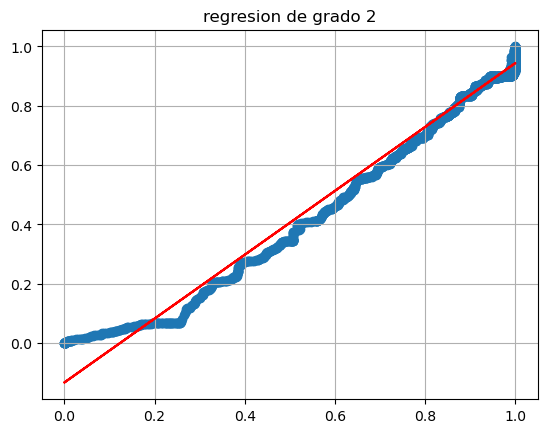

In [13]:
#np.cov(motor_db_norm['stator_winding'],motor_db_norm['stator_yoke'])
mm=polinomyal(motor_db_norm['stator_winding'],motor_db_norm['stator_yoke'],1)
plt.title('regresion de grado '+'2')


In [14]:
# evaluación de minimos cuadrados graficas


[-0.00180375  0.16912855  1.36645506 -0.58210017]
f(x)=-0.001803747941988713+0.16912855425541518x^1+1.3664550558138868x^2+-0.5821001650586674x^3


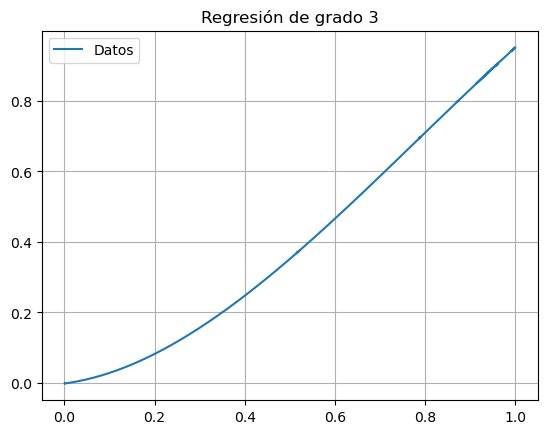

In [15]:
grado=3
rres=np.polyfit(motor_db_norm['stator_winding'],motor_db_norm['stator_yoke'],grado)
eva(motor_db_norm['stator_winding'],motor_db_norm['stator_yoke'],rres)
print(np.flip(rres))
print('f(x)='+vis(np.flip(rres)))
plt.title('Regresión de grado '+str(grado))
plt.legend(['Datos','Regresión'])
plt.grid()

<AxesSubplot:>

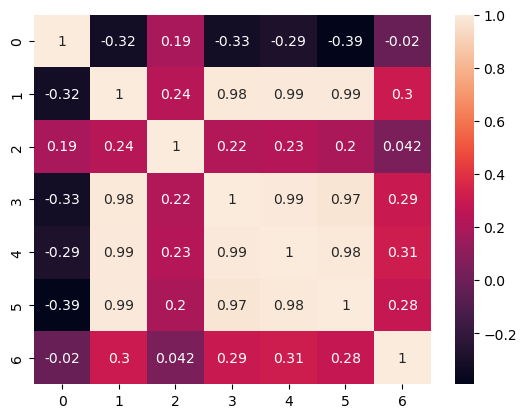

In [16]:
dim=len(motor_db_norm.columns)
col_names=motor_db_norm.columns
m_cc=np.zeros((dim,dim))

for a in range(dim):
    for b in range(dim):
        ax=motor_db_norm[col_names[a]][inicio:fin].reset_index(drop=True)
        ay=motor_db_norm[col_names[b]][inicio:fin].reset_index(drop=True)
        m_cc[a,b]=cc(ax,ay)

sns.heatmap(m_cc,annot=True)

Text(0.5, 1.0, 'Coeficiente de correlación en cada atributo')

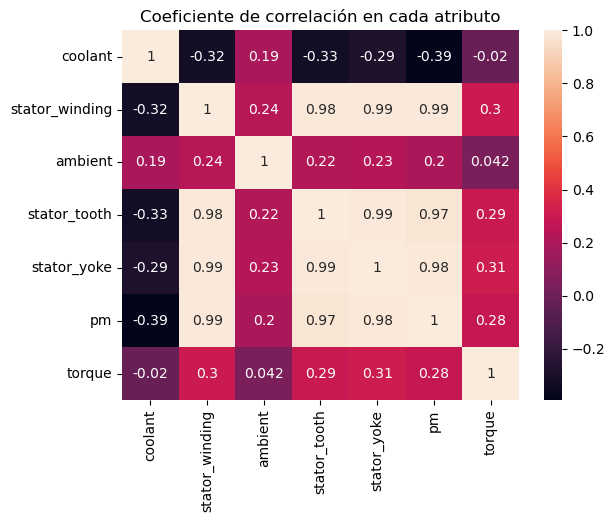

In [17]:
sns.heatmap(motor_db[inicio:fin].corr(),annot=True)
plt.title('Coeficiente de correlación en cada atributo')

In [18]:
for a in range(dim):
    #ax=motor_db_norm[col_names[a]][inicio:fin].reset_index(drop=True)
    ay=motor_db_norm[col_names[a]][inicio:fin].reset_index(drop=True)
    print('coeficiente de correlación',motor_db_norm.columns[a],': ',cc(tiempo,ay))

coeficiente de correlación coolant :  -0.4585024723548856
coeficiente de correlación stator_winding :  0.9700502488743766
coeficiente de correlación ambient :  0.17304071962394926
coeficiente de correlación stator_tooth :  0.943709093712959
coeficiente de correlación stator_yoke :  0.957736252124007
coeficiente de correlación pm :  0.9925641786192424
coeficiente de correlación torque :  0.2611378518819429


In [19]:
print(np.flip(rres))

[-0.00180375  0.16912855  1.36645506 -0.58210017]


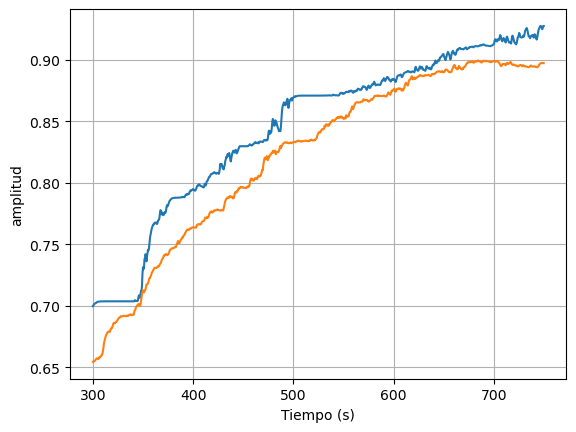

In [20]:
plt.plot(tiempo,motor_db_norm['stator_tooth'][inicio:fin])
plt.plot(tiempo,motor_db_norm['stator_yoke'][inicio:fin])
plt.xlabel('Tiempo (s)')
plt.ylabel('amplitud')
plt.grid()

# Regresiones

grado 1
MSE: 0.20075709804378178
RMSE: 0.4480592572905751
MAE: 0.3639740980154507
RAE: 0.9365264621794305
CC: 0.4585024723548854
R2: 0.21022451715554274
grado 2
MSE: 0.12109053471135209
RMSE: 0.34798065278309953
MAE: 0.2863977730206505
RAE: 0.7369180790763618
CC: 0.7236239425849015
R2: 0.5236316102821164
grado 3
MSE: 0.06151845289873675
RMSE: 0.24802913719709777
MAE: 0.20050880587043426
RAE: 0.5159207856315333
CC: 0.8706246650943814
R2: 0.7579873074707023
grado 4
MSE: 0.061452484522103855
RMSE: 0.24789611639173345
MAE: 0.2005687193830996
RAE: 0.5160749465741914
CC: 0.8707736939630276
R2: 0.7582468260980156
grado 5
MSE: 0.042015116550607336
RMSE: 0.2049758926083927
MAE: 0.1718564911547315
RAE: 0.44219671823152384
CC: 0.9136263716437242
R2: 0.834713146962876
grado 6
MSE: 0.03340015613336865
RMSE: 0.18275709598636286
MAE: 0.15605522391600288
RAE: 0.4015391412618295
CC: 0.9319894178825563
R2: 0.8686042750450659


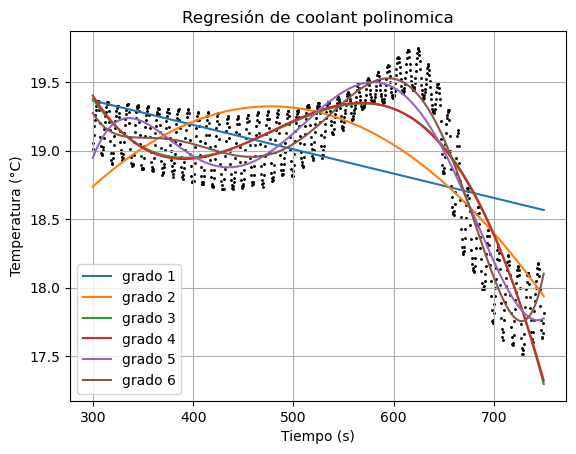

In [21]:
grado=6
grados=[]
#plt.scatter(tiempo,tiempo,motor_db['coolant'][inicio:fin].reset_index(drop=True))
ii='coolant'
metrics=np.zeros((grado,6))
for tt in range(grado):
    r=np.polyfit(tiempo,motor_db[ii][inicio:fin].reset_index(drop=True),tt+1)
    pred=eva(tiempo,motor_db[ii][inicio:fin].reset_index(drop=True),r)
    grados.append('grado '+str(tt+1))
    print('grado '+str(tt+1))
    mse1=mse(motor_db[ii][inicio:fin].reset_index(drop=True),pred)
    print('MSE:',mse1)
    rmse1=rmse(motor_db[ii][inicio:fin].reset_index(drop=True),pred)
    print('RMSE:',rmse1)
    mae1=mae(motor_db[ii][inicio:fin].reset_index(drop=True),pred)
    print('MAE:',mae1)
    rae1=rae(motor_db[ii][inicio:fin].reset_index(drop=True),np.array(pred))
    print('RAE:',rae1)
    cc1=cc(motor_db[ii][inicio:fin].reset_index(drop=True),np.array(pred))
    print('CC:',cc1)
    r21=r2(motor_db[ii][inicio:fin].reset_index(drop=True),pred)
    print('R2:',r21)
    metrics[tt,:]=[mse1,rmse1,mae1,rae1,cc1,r21]
plt.grid()
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Regresión de '+ ii + ' polinomica')
plt.legend(grados)
plt.scatter(tiempo,motor_db[ii][inicio:fin].reset_index(drop=True),s=1.2,c='k')

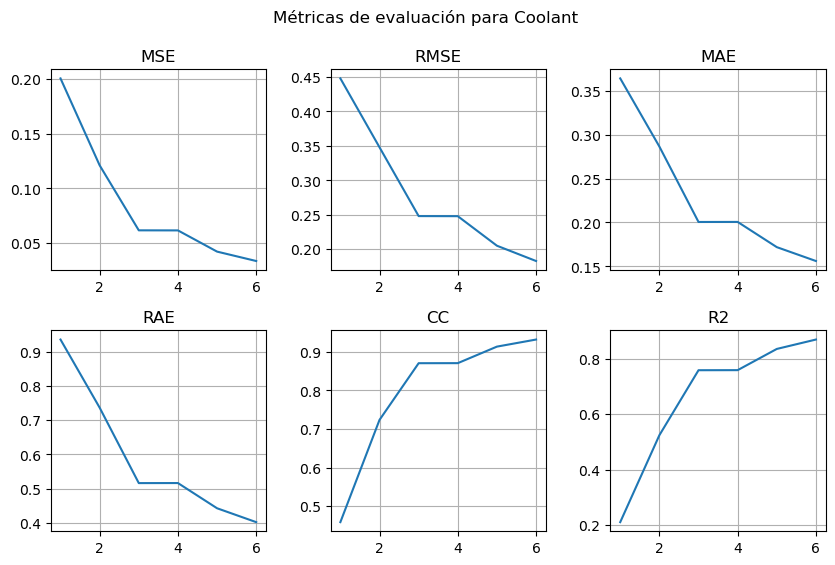

In [22]:
# Creamos una figura con 6 subplots
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
gr=np.arange(1,grado+1,1)
# Dibujamos cada gráfica en su subplot correspondiente
axs[0, 0].plot(gr,metrics[:,0])
axs[0, 0].set_title('MSE')
axs[0, 0].grid(True)
axs[0, 1].plot(gr,metrics[:,1])
axs[0, 1].set_title('RMSE')
axs[0, 1].grid(True)
axs[0, 2].plot(gr,metrics[:,2])
axs[0, 2].set_title('MAE')
axs[0, 2].grid(True)
axs[1, 0].plot(gr,metrics[:,3])
axs[1, 0].set_title('RAE')
axs[1, 0].grid(True)
axs[1, 1].plot(gr,metrics[:,4])
axs[1, 1].set_title('CC')
axs[1, 1].grid(True)
axs[1, 2].plot(gr,metrics[:,5])
axs[1, 2].set_title('R2')
axs[1, 2].grid(True)
# Ajustamos los márgenes entre los subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.suptitle('Métricas de evaluación para Coolant')
# Mostramos la figura
plt.show()

## Temperatura de los devanados del estator

grado 1
MSE: 0.5225236210548798
RMSE: 0.7228579535807016
MAE: 0.605606647247954
RAE: 0.2401524295646302
CC: 0.970050248874378
R2: 0.9409974853412413
grado 2
MSE: 0.06378782943459899
RMSE: 0.2525625257923253
MAE: 0.19902680579553977
RAE: 0.07892378853087
CC: 0.9963920826594234
R2: 0.9927971823863825
grado 3
MSE: 0.05086645102861406
RMSE: 0.22553591959733169
MAE: 0.1791617808393038
RAE: 0.07104634196009477
CC: 0.997123985947313
R2: 0.9942562433514568
grado 4
MSE: 0.0359464821833278
RMSE: 0.1895955753263451
MAE: 0.14748830277602426
RAE: 0.05848627059326863
CC: 0.9979684273000471
R2: 0.9959409818877263
grado 5
MSE: 0.03184489963462953
RMSE: 0.17845139291871479
MAE: 0.1409332468262722
RAE: 0.05588687275076029
CC: 0.9982004437468203
R2: 0.9964041258963457
grado 6
MSE: 0.024854387974187576
RMSE: 0.15765274489899495
MAE: 0.12288177586803975
RAE: 0.04872858836346894
CC: 0.9985957555819274
R2: 0.9971934830662373


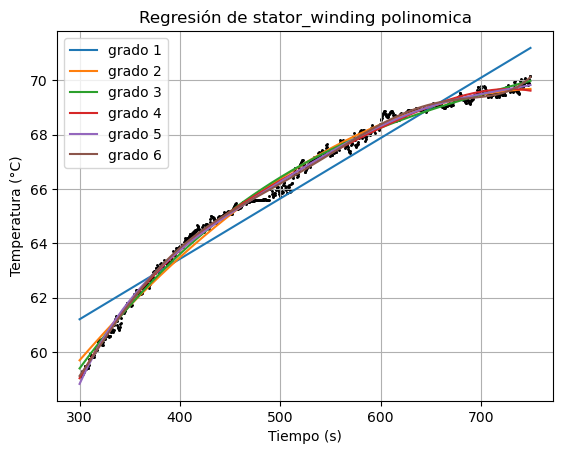

In [23]:
grado=6
grados=[]
#plt.scatter(tiempo,tiempo,motor_db['coolant'][inicio:fin].reset_index(drop=True))
ii='stator_winding' #'coolant', 'stator_winding', 'ambient', 'stator_tooth', 'stator_yoke','pm', 'torque'
metrics=np.zeros((grado,6))
for tt in range(grado):
    r=np.polyfit(tiempo,motor_db[ii][inicio:fin].reset_index(drop=True),tt+1)
    pred=eva(tiempo,motor_db[ii][inicio:fin].reset_index(drop=True),r)
    grados.append('grado '+str(tt+1))
    print('grado '+str(tt+1))
    mse1=mse(motor_db[ii][inicio:fin].reset_index(drop=True),pred)
    print('MSE:',mse1)
    rmse1=rmse(motor_db[ii][inicio:fin].reset_index(drop=True),pred)
    print('RMSE:',rmse1)
    mae1=mae(motor_db[ii][inicio:fin].reset_index(drop=True),pred)
    print('MAE:',mae1)
    rae1=rae(motor_db[ii][inicio:fin].reset_index(drop=True),np.array(pred))
    print('RAE:',rae1)
    cc1=cc(motor_db[ii][inicio:fin].reset_index(drop=True),np.array(pred))
    print('CC:',cc1)
    r21=r2(motor_db[ii][inicio:fin].reset_index(drop=True),pred)
    print('R2:',r21)
    metrics[tt,:]=[mse1,rmse1,mae1,rae1,cc1,r21]
plt.grid()
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Regresión de '+ ii + ' polinomica')
plt.legend(grados)
plt.scatter(tiempo,motor_db[ii][inicio:fin].reset_index(drop=True),s=1.2,c='k')

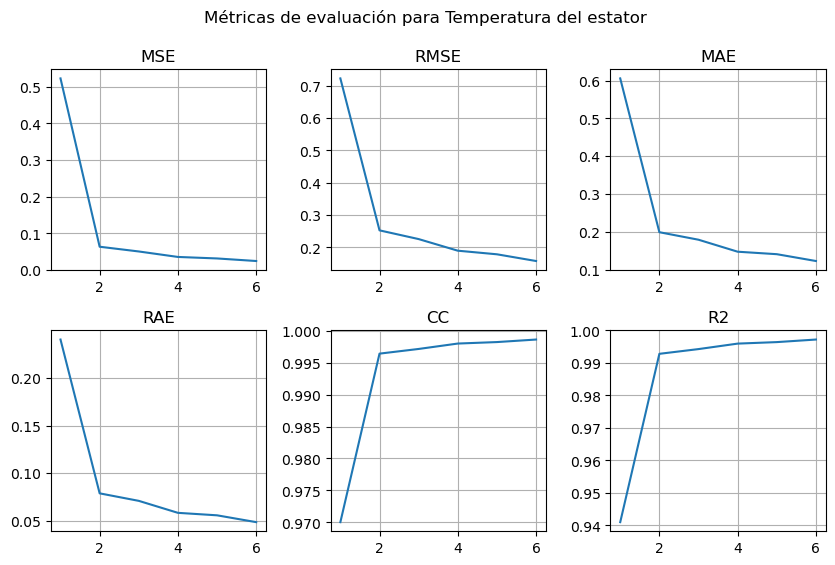

In [24]:
# Creamos una figura con 6 subplots
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
gr=np.arange(1,grado+1,1)
# Dibujamos cada gráfica en su subplot correspondiente
axs[0, 0].plot(gr,metrics[:,0])
axs[0, 0].set_title('MSE')
axs[0, 0].grid(True)
axs[0, 1].plot(gr,metrics[:,1])
axs[0, 1].set_title('RMSE')
axs[0, 1].grid(True)
axs[0, 2].plot(gr,metrics[:,2])
axs[0, 2].set_title('MAE')
axs[0, 2].grid(True)
axs[1, 0].plot(gr,metrics[:,3])
axs[1, 0].set_title('RAE')
axs[1, 0].grid(True)
axs[1, 1].plot(gr,metrics[:,4])
axs[1, 1].set_title('CC')
axs[1, 1].grid(True)
axs[1, 2].plot(gr,metrics[:,5])
axs[1, 2].set_title('R2')
axs[1, 2].grid(True)
# Ajustamos los márgenes entre los subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.suptitle('Métricas de evaluación para Temperatura del estator')
# Mostramos la figura
plt.show()

## Temperatura ambiente

grado 1
MSE: 0.15178443530802657
RMSE: 0.38959521982183837
MAE: 0.32226127092101237
RAE: 0.9801665655724762
CC: 0.17304071962394893
R2: 0.02994309064797337
grado 2
MSE: 0.14387938984989132
RMSE: 0.3793143681036764
MAE: 0.31611003547353217
RAE: 0.9614574128860456
CC: 0.28366242386154217
R2: 0.08046437071100529
grado 3
MSE: 0.14309324208174806
RMSE: 0.37827667398578524
MAE: 0.31597442918911156
RAE: 0.9610449626226594
CC: 0.2923844292657682
R2: 0.08548865447706763
grado 4
MSE: 0.14038517905450468
RMSE: 0.3746801022932826
MAE: 0.3124300143755866
RAE: 0.95026452696929
CC: 0.3206180459271105
R2: 0.10279593137411645
grado 5
MSE: 0.11631167069513303
RMSE: 0.3410449687286605
MAE: 0.2861880447018256
RAE: 0.8704488506533734
CC: 0.5066064873434308
R2: 0.25665013301844875
grado 6
MSE: 0.11207366739478837
RMSE: 0.3347740542437367
MAE: 0.28072531919637805
RAE: 0.853833819991957
CC: 0.532668080740474
R2: 0.28373528423973887
grado 7
MSE: 0.11199165462169357
RMSE: 0.3346515420877268
MAE: 0.2809994324602

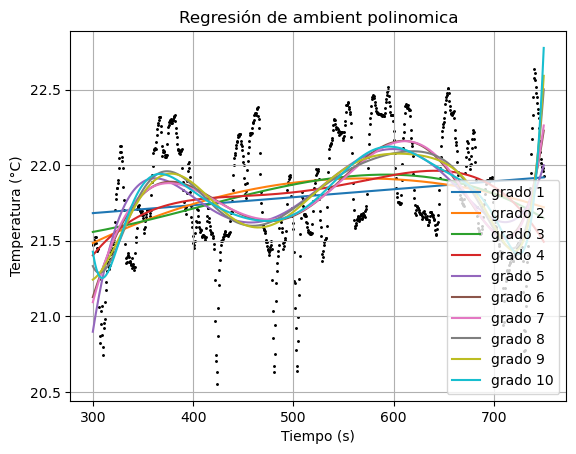

In [25]:
grado=10
grados=[]
#plt.scatter(tiempo,tiempo,motor_db['coolant'][inicio:fin].reset_index(drop=True))
ii='ambient' #'coolant', 'stator_winding', 'ambient', 'stator_tooth', 'stator_yoke','pm', 'torque'
metrics=np.zeros((grado,6))
for tt in range(grado):
    r=np.polyfit(tiempo,motor_db[ii][inicio:fin].reset_index(drop=True),tt+1)
    pred=eva(tiempo,motor_db[ii][inicio:fin].reset_index(drop=True),r)
    grados.append('grado '+str(tt+1))
    print('grado '+str(tt+1))
    mse1=mse(motor_db[ii][inicio:fin].reset_index(drop=True),pred)
    print('MSE:',mse1)
    rmse1=rmse(motor_db[ii][inicio:fin].reset_index(drop=True),pred)
    print('RMSE:',rmse1)
    mae1=mae(motor_db[ii][inicio:fin].reset_index(drop=True),pred)
    print('MAE:',mae1)
    rae1=rae(motor_db[ii][inicio:fin].reset_index(drop=True),np.array(pred))
    print('RAE:',rae1)
    cc1=cc(motor_db[ii][inicio:fin].reset_index(drop=True),np.array(pred))
    print('CC:',cc1)
    r21=r2(motor_db[ii][inicio:fin].reset_index(drop=True),pred)
    print('R2:',r21)
    metrics[tt,:]=[mse1,rmse1,mae1,rae1,cc1,r21]
plt.grid()
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Regresión de '+ ii + ' polinomica')
plt.legend(grados)
plt.scatter(tiempo,motor_db[ii][inicio:fin].reset_index(drop=True),s=1.2,c='k')

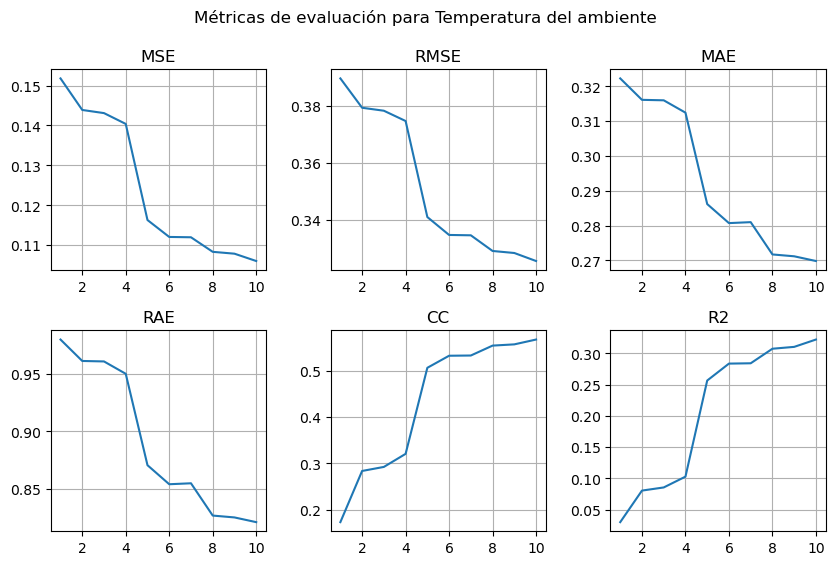

In [26]:
# Creamos una figura con 6 subplots
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
gr=np.arange(1,grado+1,1)
# Dibujamos cada gráfica en su subplot correspondiente
axs[0, 0].plot(gr,metrics[:,0])
axs[0, 0].set_title('MSE')
axs[0, 0].grid(True)
axs[0, 1].plot(gr,metrics[:,1])
axs[0, 1].set_title('RMSE')
axs[0, 1].grid(True)
axs[0, 2].plot(gr,metrics[:,2])
axs[0, 2].set_title('MAE')
axs[0, 2].grid(True)
axs[1, 0].plot(gr,metrics[:,3])
axs[1, 0].set_title('RAE')
axs[1, 0].grid(True)
axs[1, 1].plot(gr,metrics[:,4])
axs[1, 1].set_title('CC')
axs[1, 1].grid(True)
axs[1, 2].plot(gr,metrics[:,5])
axs[1, 2].set_title('R2')
axs[1, 2].grid(True)
# Ajustamos los márgenes entre los subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.suptitle('Métricas de evaluación para Temperatura del ambiente')
# Mostramos la figura
plt.show()

## Temperatura de los dientes del estator

grado 1
MSE: 0.7555335502142282
RMSE: 0.8692143292734124
MAE: 0.7039535691668678
RAE: 0.32106988824399807
CC: 0.9437090937129581
R2: 0.8905868535565329
grado 2
MSE: 0.16380826512161503
RMSE: 0.40473233762774014
MAE: 0.3206737771741262
RAE: 0.1462577907260695
CC: 0.9880678041895997
R2: 0.9762779856760568
grado 3
MSE: 0.10333380558827142
RMSE: 0.32145575992393016
MAE: 0.22342981355339975
RAE: 0.10190527956675886
CC: 0.9924896165634534
R2: 0.9850356389862707
grado 4
MSE: 0.10226818239648078
RMSE: 0.31979396866807974
MAE: 0.22905117493680296
RAE: 0.10446915586514094
CC: 0.9925673569043544
R2: 0.9851899579920962


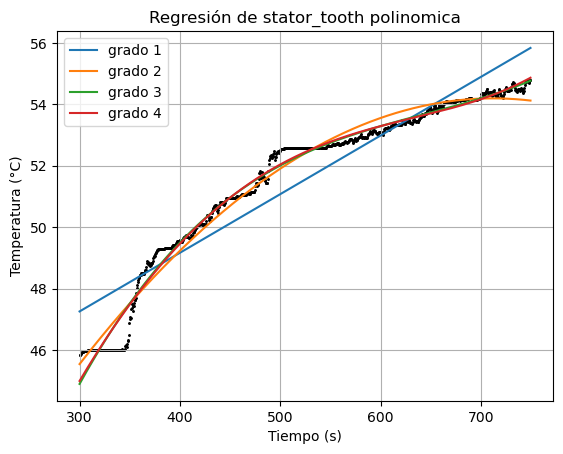

In [35]:
grado=4
grados=[]
#plt.scatter(tiempo,tiempo,motor_db['coolant'][inicio:fin].reset_index(drop=True))
ii='stator_tooth' #'coolant', 'stator_winding', 'ambient', 'stator_tooth', 'stator_yoke','pm', 'torque'
metrics=np.zeros((grado,6))
for tt in range(grado):
    r=np.polyfit(tiempo,motor_db[ii][inicio:fin].reset_index(drop=True),tt+1)
    pred=eva(tiempo,motor_db[ii][inicio:fin].reset_index(drop=True),r)
    grados.append('grado '+str(tt+1))
    print('grado '+str(tt+1))
    mse1=mse(motor_db[ii][inicio:fin].reset_index(drop=True),pred)
    print('MSE:',mse1)
    rmse1=rmse(motor_db[ii][inicio:fin].reset_index(drop=True),pred)
    print('RMSE:',rmse1)
    mae1=mae(motor_db[ii][inicio:fin].reset_index(drop=True),pred)
    print('MAE:',mae1)
    rae1=rae(motor_db[ii][inicio:fin].reset_index(drop=True),np.array(pred))
    print('RAE:',rae1)
    cc1=cc(motor_db[ii][inicio:fin].reset_index(drop=True),np.array(pred))
    print('CC:',cc1)
    r21=r2(motor_db[ii][inicio:fin].reset_index(drop=True),pred)
    print('R2:',r21)
    metrics[tt,:]=[mse1,rmse1,mae1,rae1,cc1,r21]
plt.grid()
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Regresión de '+ ii + ' polinomica')
plt.legend(grados)
plt.scatter(tiempo,motor_db[ii][inicio:fin].reset_index(drop=True),s=1.2,c='k')

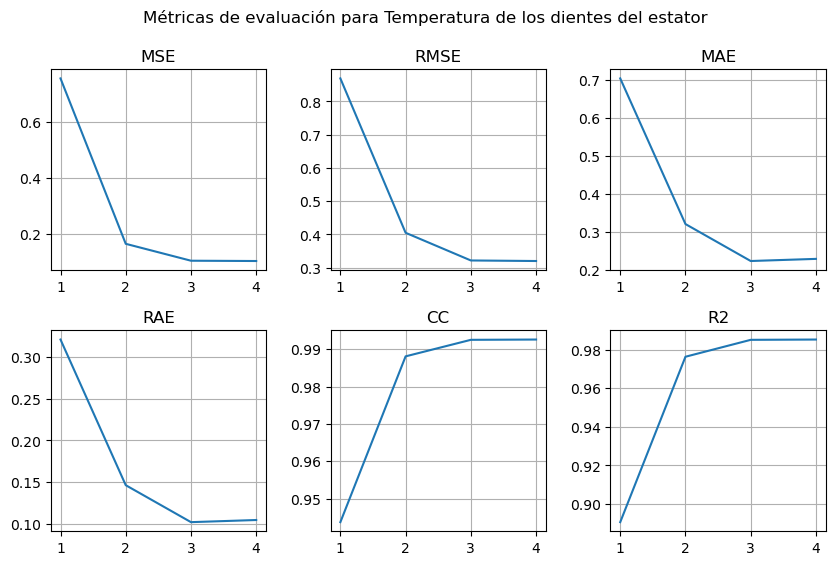

In [36]:
# Creamos una figura con 6 subplots
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
gr=np.arange(1,grado+1,1)
# Dibujamos cada gráfica en su subplot correspondiente
axs[0, 0].plot(gr,metrics[:,0])
axs[0, 0].set_title('MSE')
axs[0, 0].grid(True)
axs[0, 1].plot(gr,metrics[:,1])
axs[0, 1].set_title('RMSE')
axs[0, 1].grid(True)
axs[0, 2].plot(gr,metrics[:,2])
axs[0, 2].set_title('MAE')
axs[0, 2].grid(True)
axs[1, 0].plot(gr,metrics[:,3])
axs[1, 0].set_title('RAE')
axs[1, 0].grid(True)
axs[1, 1].plot(gr,metrics[:,4])
axs[1, 1].set_title('CC')
axs[1, 1].grid(True)
axs[1, 2].plot(gr,metrics[:,5])
axs[1, 2].set_title('R2')
axs[1, 2].grid(True)
# Ajustamos los márgenes entre los subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.suptitle('Métricas de evaluación para Temperatura de los dientes del estator')
# Mostramos la figura
plt.show()

## Temperatura del yugo del estator

grado 1
MSE: 0.231995310114849
RMSE: 0.48165891470505245
MAE: 0.4002658922284293
RAE: 0.28049588331948583
CC: 0.9577362521240061
R2: 0.9172587286325399
grado 2
MSE: 0.008049787808809862
RMSE: 0.08972060972156766
MAE: 0.07206528867040331
RAE: 0.050501472133285076
CC: 0.998563487306113
R2: 0.9971290381809464
grado 3
MSE: 0.007677869640159826
RMSE: 0.08762345371052105
MAE: 0.07305191741261628
RAE: 0.05119287578752771
CC: 0.9986299029303465
R2: 0.9972616830266701
grado 4
MSE: 0.005956246333855493
RMSE: 0.07717672145054812
MAE: 0.06004829816326324
RAE: 0.042080279039923826
CC: 0.9989372858431061
R2: 0.9978757010475902
grado 5
MSE: 0.0059547529069679875
RMSE: 0.0771670454725849
MAE: 0.06010191982514009
RAE: 0.04211785570010206
CC: 0.998937552442202
R2: 0.9978762336792165


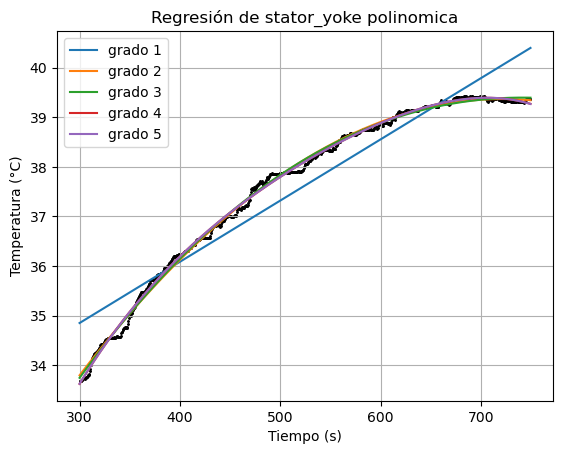

In [29]:
grado=5
grados=[]
#plt.scatter(tiempo,tiempo,motor_db['coolant'][inicio:fin].reset_index(drop=True))
ii='stator_yoke' #'coolant', 'stator_winding', 'ambient', 'stator_tooth', 'stator_yoke','pm', 'torque'
metrics=np.zeros((grado,6))
for tt in range(grado):
    r=np.polyfit(tiempo,motor_db[ii][inicio:fin].reset_index(drop=True),tt+1)
    pred=eva(tiempo,motor_db[ii][inicio:fin].reset_index(drop=True),r)
    grados.append('grado '+str(tt+1))
    print('grado '+str(tt+1))
    mse1=mse(motor_db[ii][inicio:fin].reset_index(drop=True),pred)
    print('MSE:',mse1)
    rmse1=rmse(motor_db[ii][inicio:fin].reset_index(drop=True),pred)
    print('RMSE:',rmse1)
    mae1=mae(motor_db[ii][inicio:fin].reset_index(drop=True),pred)
    print('MAE:',mae1)
    rae1=rae(motor_db[ii][inicio:fin].reset_index(drop=True),np.array(pred))
    print('RAE:',rae1)
    cc1=cc(motor_db[ii][inicio:fin].reset_index(drop=True),np.array(pred))
    print('CC:',cc1)
    r21=r2(motor_db[ii][inicio:fin].reset_index(drop=True),pred)
    print('R2:',r21)
    metrics[tt,:]=[mse1,rmse1,mae1,rae1,cc1,r21]
plt.grid()
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Regresión de '+ ii + ' polinomica')
plt.legend(grados)
plt.scatter(tiempo,motor_db[ii][inicio:fin].reset_index(drop=True),s=1.2,c='k')

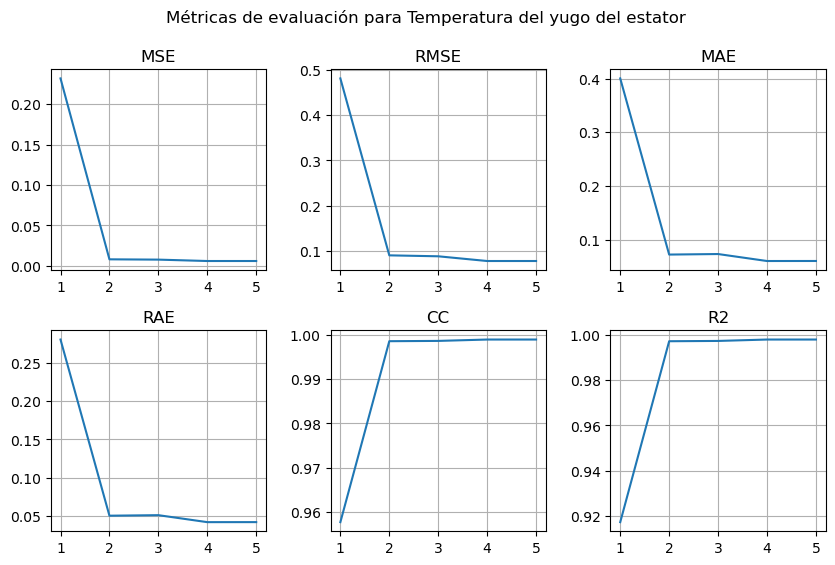

In [30]:
# Creamos una figura con 6 subplots
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
gr=np.arange(1,grado+1,1)
# Dibujamos cada gráfica en su subplot correspondiente
axs[0, 0].plot(gr,metrics[:,0])
axs[0, 0].set_title('MSE')
axs[0, 0].grid(True)
axs[0, 1].plot(gr,metrics[:,1])
axs[0, 1].set_title('RMSE')
axs[0, 1].grid(True)
axs[0, 2].plot(gr,metrics[:,2])
axs[0, 2].set_title('MAE')
axs[0, 2].grid(True)
axs[1, 0].plot(gr,metrics[:,3])
axs[1, 0].set_title('RAE')
axs[1, 0].grid(True)
axs[1, 1].plot(gr,metrics[:,4])
axs[1, 1].set_title('CC')
axs[1, 1].grid(True)
axs[1, 2].plot(gr,metrics[:,5])
axs[1, 2].set_title('R2')
axs[1, 2].grid(True)
# Ajustamos los márgenes entre los subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.suptitle('Métricas de evaluación para Temperatura del yugo del estator')
# Mostramos la figura
plt.show()

## Temperatura del imán permanente

grado 1
MSE: 0.2587673815492282
RMSE: 0.5086918335782757
MAE: 0.4351372309581383
RAE: 0.12091978854632464
CC: 0.9925641786192438
R2: 0.9851836486780939
grado 2
MSE: 0.003632514241512242
RMSE: 0.0602703429682646
MAE: 0.048928210844097327
RAE: 0.013596604676163448
CC: 0.9998960004045554
R2: 0.9997920116250284
grado 3
MSE: 0.0017180715796593457
RMSE: 0.04144962701471927
MAE: 0.032453392607420986
RAE: 0.0090184362369069
CC: 0.9999508126216886
R2: 0.9999016276627757
grado 4
MSE: 0.001710749695163902
RMSE: 0.04136121003021916
MAE: 0.03234770934575522
RAE: 0.008989068035924943
CC: 0.9999510222480691
R2: 0.9999020468949539
grado 5
MSE: 0.001709596291825432
RMSE: 0.041347264623254484
MAE: 0.03233185382695085
RAE: 0.008984661963898206
CC: 0.9999510552701312
R2: 0.9999021129358474


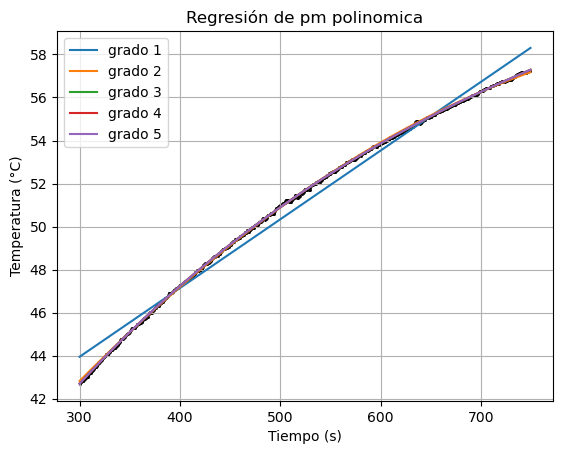

In [31]:
grado=5
grados=[]
#plt.scatter(tiempo,tiempo,motor_db['coolant'][inicio:fin].reset_index(drop=True))
ii='pm' #'coolant', 'stator_winding', 'ambient', 'stator_tooth', 'stator_yoke','pm', 'torque'
metrics=np.zeros((grado,6))
for tt in range(grado):
    r=np.polyfit(tiempo,motor_db[ii][inicio:fin].reset_index(drop=True),tt+1)
    pred=eva(tiempo,motor_db[ii][inicio:fin].reset_index(drop=True),r)
    grados.append('grado '+str(tt+1))
    print('grado '+str(tt+1))
    mse1=mse(motor_db[ii][inicio:fin].reset_index(drop=True),pred)
    print('MSE:',mse1)
    rmse1=rmse(motor_db[ii][inicio:fin].reset_index(drop=True),pred)
    print('RMSE:',rmse1)
    mae1=mae(motor_db[ii][inicio:fin].reset_index(drop=True),pred)
    print('MAE:',mae1)
    rae1=rae(motor_db[ii][inicio:fin].reset_index(drop=True),np.array(pred))
    print('RAE:',rae1)
    cc1=cc(motor_db[ii][inicio:fin].reset_index(drop=True),np.array(pred))
    print('CC:',cc1)
    r21=r2(motor_db[ii][inicio:fin].reset_index(drop=True),pred)
    print('R2:',r21)
    metrics[tt,:]=[mse1,rmse1,mae1,rae1,cc1,r21]
plt.grid()
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Regresión de '+ ii + ' polinomica')
plt.legend(grados)
plt.scatter(tiempo,motor_db[ii][inicio:fin].reset_index(drop=True),s=1.2,c='k')

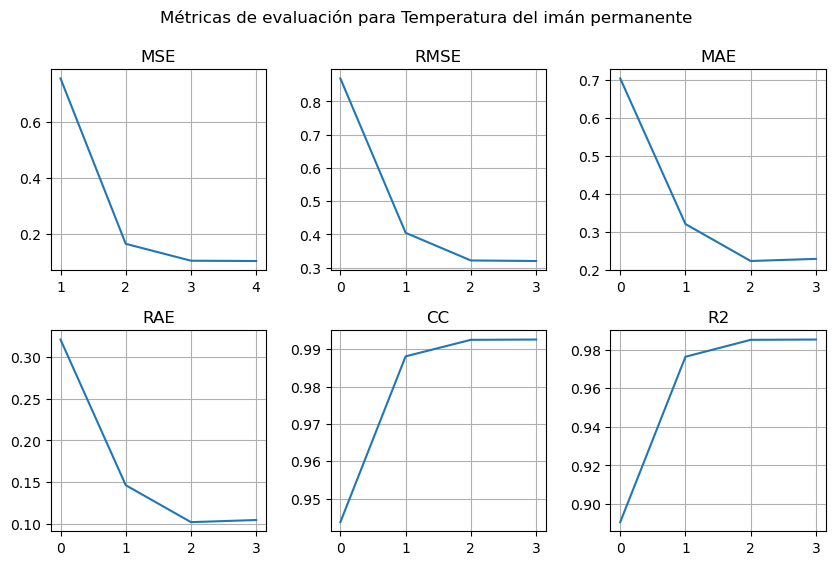

In [37]:
# Creamos una figura con 6 subplots
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
gr=np.arange(1,grado+1,1)
# Dibujamos cada gráfica en su subplot correspondiente
axs[0, 0].plot(gr,metrics[:,0])
axs[0, 0].set_title('MSE')
axs[0, 0].grid(True)
axs[0, 1].plot(metrics[:,1])
axs[0, 1].set_title('RMSE')
axs[0, 1].grid(True)
axs[0, 2].plot(metrics[:,2])
axs[0, 2].set_title('MAE')
axs[0, 2].grid(True)
axs[1, 0].plot(metrics[:,3])
axs[1, 0].set_title('RAE')
axs[1, 0].grid(True)
axs[1, 1].plot(metrics[:,4])
axs[1, 1].set_title('CC')
axs[1, 1].grid(True)
axs[1, 2].plot(metrics[:,5])
axs[1, 2].set_title('R2')
axs[1, 2].grid(True)
# Ajustamos los márgenes entre los subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.suptitle('Métricas de evaluación para Temperatura del imán permanente')
# Mostramos la figura
plt.show()

## Par del motor

grado 1
MSE: 0.007712002443650902
RMSE: 0.08781800751355556
MAE: 0.06918721313398322
RAE: 0.973668097109817
CC: 0.2611378518819438
R2: 0.06819297768551552
grado 2
MSE: 0.007383140302425495
RMSE: 0.08592520178868068
MAE: 0.06819658661676932
RAE: 0.9597270610097748
CC: 0.3285238658263261
R2: 0.10792793041747344
grado 3
MSE: 0.007360329533893981
RMSE: 0.08579236291124041
MAE: 0.06815685629210455
RAE: 0.959167938191242
CC: 0.3326921314428548
R2: 0.11068405432398938
grado 4
MSE: 0.007209997466952213
RMSE: 0.08491170394564117
MAE: 0.06824057582181593
RAE: 0.9603461188331932
CC: 0.35895405090448584
R2: 0.12884801066074006
grado 5
MSE: 0.007176799772629185
RMSE: 0.08471599478628097
MAE: 0.06808875530882277
RAE: 0.9582095565510554
CC: 0.3644984783286814
R2: 0.13285914070392552


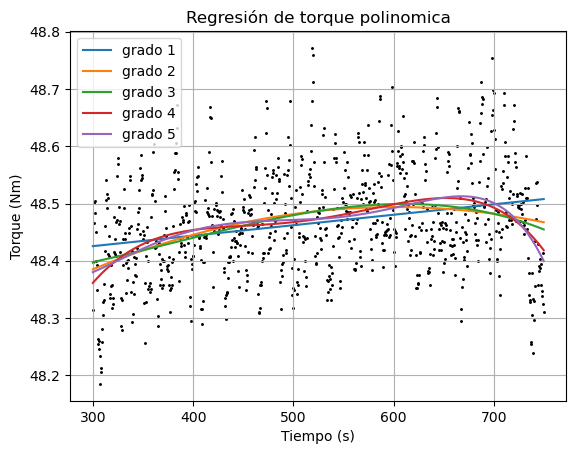

In [38]:
grado=5
grados=[]
#plt.scatter(tiempo,tiempo,motor_db['coolant'][inicio:fin].reset_index(drop=True))
ii='torque' #'coolant', 'stator_winding', 'ambient', 'stator_tooth', 'stator_yoke','pm', 'torque'
metrics=np.zeros((grado,6))
for tt in range(grado):
    r=np.polyfit(tiempo,motor_db[ii][inicio:fin].reset_index(drop=True),tt+1)
    pred=eva(tiempo,motor_db[ii][inicio:fin].reset_index(drop=True),r)
    grados.append('grado '+str(tt+1))
    print('grado '+str(tt+1))
    mse1=mse(motor_db[ii][inicio:fin].reset_index(drop=True),pred)
    print('MSE:',mse1)
    rmse1=rmse(motor_db[ii][inicio:fin].reset_index(drop=True),pred)
    print('RMSE:',rmse1)
    mae1=mae(motor_db[ii][inicio:fin].reset_index(drop=True),pred)
    print('MAE:',mae1)
    rae1=rae(motor_db[ii][inicio:fin].reset_index(drop=True),np.array(pred))
    print('RAE:',rae1)
    cc1=cc(motor_db[ii][inicio:fin].reset_index(drop=True),np.array(pred))
    print('CC:',cc1)
    r21=r2(motor_db[ii][inicio:fin].reset_index(drop=True),pred)
    print('R2:',r21)
    metrics[tt,:]=[mse1,rmse1,mae1,rae1,cc1,r21]
plt.grid()
plt.xlabel('Tiempo (s)')
plt.ylabel('Torque (Nm)')
plt.title('Regresión de '+ ii + ' polinomica')
plt.legend(grados)
plt.scatter(tiempo,motor_db[ii][inicio:fin].reset_index(drop=True),s=1.2,c='k')

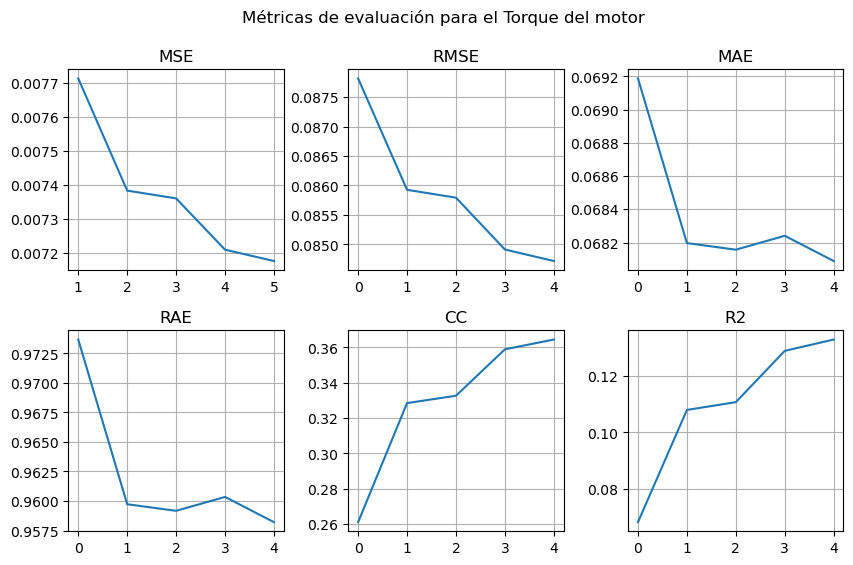

In [34]:
# Creamos una figura con 6 subplots
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
gr=np.arange(1,grado+1,1)
# Dibujamos cada gráfica en su subplot correspondiente
axs[0, 0].plot(gr,metrics[:,0])
axs[0, 0].set_title('MSE')
axs[0, 0].grid(True)
axs[0, 1].plot(metrics[:,1])
axs[0, 1].set_title('RMSE')
axs[0, 1].grid(True)
axs[0, 2].plot(metrics[:,2])
axs[0, 2].set_title('MAE')
axs[0, 2].grid(True)
axs[1, 0].plot(metrics[:,3])
axs[1, 0].set_title('RAE')
axs[1, 0].grid(True)
axs[1, 1].plot(metrics[:,4])
axs[1, 1].set_title('CC')
axs[1, 1].grid(True)
axs[1, 2].plot(metrics[:,5])
axs[1, 2].set_title('R2')
axs[1, 2].grid(True)
# Ajustamos los márgenes entre los subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.suptitle('Métricas de evaluación para el Torque del motor')
# Mostramos la figura
plt.show()